# Neural Style Transfer

In this lab, we'll perform neural style transfer employing a pre-trained [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) model as the feature extractor. We'll demonstrate how to extract outputs from specific layers of the model to compute the style and content loss, and then utilize that information to modify the content image.

### Imports

In [ ]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K

from tqdm import tqdm
from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

## Utilities

Let's define some functions to for loading, visualizing, and preprocessing the images.

In [ ]:
def tensor_to_image(tensor):
  '''Converts a tensor to an image'''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor)


def load_img(path_to_img):
  '''Loads an image as a tensor and scales it to 512 pixels'''
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image


def load_images(content_path, style_path):
  '''Loads the content and path images as tensors'''
  content_image = load_img("{}".format(content_path))
  style_image = load_img("{}".format(style_path))

  return content_image, style_image


def imshow(image, title=None):
  '''Displays an image with a corresponding title'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)


def show_images_with_objects(images, titles=[]):
  '''Displays a row of images with corresponding titles'''
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)


def display_gif(gif_path):
  '''Displays the generated images as an animated gif'''
  with open(gif_path,'rb') as f:
    display_fn(Image(data=f.read(), format='png'))


def create_gif(gif_path, images):
  '''Creates animation of generated images'''
  mimsave(gif_path, images, fps=1)

  return gif_path


def clip_image_values(image, min_value=0.0, max_value=255.0):
  '''Clips the image pixel values by the given min and max'''
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)


def preprocess_image(image):
  '''Centers the pixel values of a given image to use with VGG-19'''
  image = tf.cast(image, dtype=tf.float32)
  image = tf.keras.applications.vgg19.preprocess_input(image)

  return image


## Download Images

We will download a few images and choose which one will be the content and style image. Let's use the swan as the content image and Tom and Jerry (`tnj.jpg`) as the style image.

In [ ]:
IMAGE_DIR = 'images'

# Create directory
!mkdir {IMAGE_DIR}

# Download images to the directory just created
!wget -q -O ./images/cafe.jpg https://cdn.pixabay.com/photo/2018/07/14/15/27/cafe-3537801_1280.jpg
!wget -q -O ./images/swan.jpg https://cdn.pixabay.com/photo/2017/02/28/23/00/swan-2107052_1280.jpg
!wget -q -O ./images/tnj.jpg https://i.dawn.com/large/2019/10/5db6a03a4c7e3.jpg
!wget -q -O ./images/rudolph.jpg https://cdn.pixabay.com/photo/2015/09/22/12/21/rudolph-951494_1280.jpg
!wget -q -O ./images/dynamite.jpg https://cdn.pixabay.com/photo/2015/10/13/02/59/animals-985500_1280.jpg
!wget -q -O ./images/painting.jpg https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg

print("Image files to choose from: ")
!ls images

mkdir: cannot create directory ‘images’: File exists
Image files to choose from: 
cafe.jpg  dynamite.jpg	painting.jpg  rudolph.jpg  swan.jpg  tnj.jpg


In [ ]:
# Set default images
content_path = f'{IMAGE_DIR}/tnj.jpg'
style_path = f'{IMAGE_DIR}/painting.jpg'

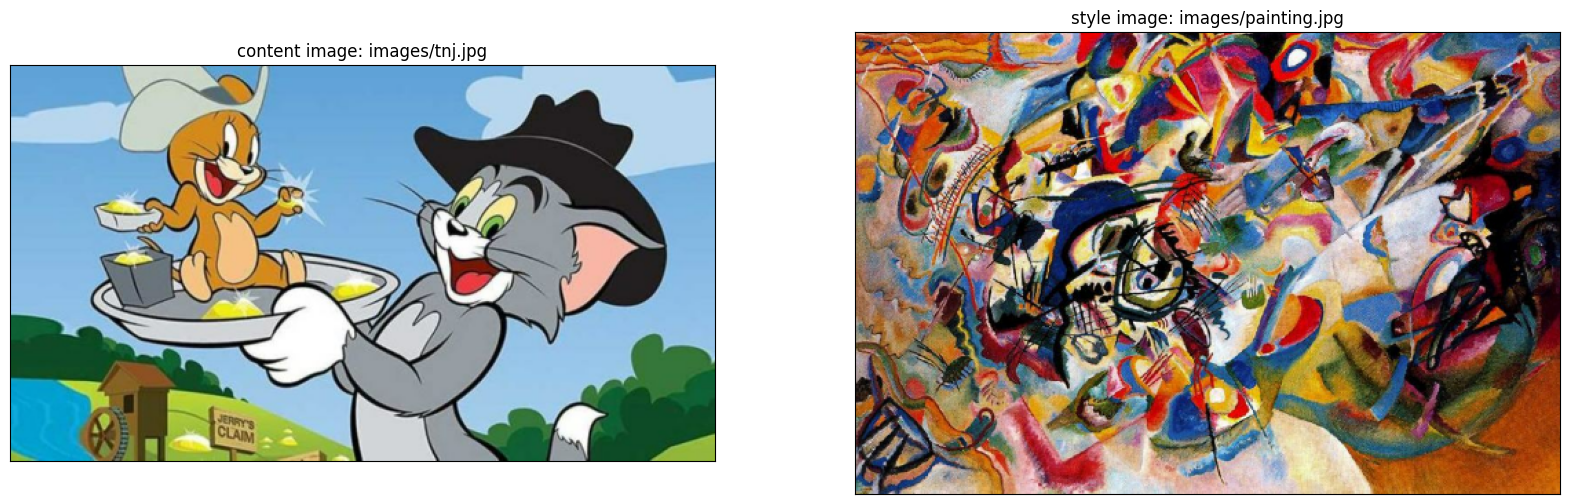

In [ ]:
# Display the content and style image
content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image],
                         titles=[f'content image: {content_path}',
                                 f'style image: {style_path}'])

## Build the model

<img src="https://drive.google.com/uc?export=view&id=1xNii3cDPob5cX8QpXPu3S3ps8s9O5X15" width="75%" height="75%"/>

As mentioned, we'll utilize the VGG-19 model as the feature extractor. By providing both the style and content images, and based on the computed losses, we'll generate a new image that amalgamates elements from both the content and style images. We can download a temporary copy of the model solely for inspecting the available layers that can be utilized.

In [ ]:
# Clear session to make layer naming consistent when re-running this cell
K.clear_session()

# Download the vgg19 model and inspect the layers
tmp_vgg = tf.keras.applications.vgg19.VGG19()
tmp_vgg.summary()

# Delete temporary variable
del tmp_vgg

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Select intermediate layers from the network to extract the style and content of the image:

- We'll utilize the first layer of each convolutional block for the style layers.
- For the content layer, we'll use the second convolutional layer of the last convolutional block (only one layer).

In [ ]:
# Style layers of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# Choose the content layer and put in a list
content_layers = ['block5_conv2']

# Combine the two lists (put the style layers before the content layers)
output_layers = style_layers + content_layers

# Declare auxiliary variables holding the number of style and content layers
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

Define the model to accept the same input as the standard VGG-19 model and output only the selected content and style layers.

In [ ]:
def vgg_model(layer_names):
  """ Creates a vgg model that outputs the style and content layer activations.

  Args:
    layer_names: a list of strings, representing the names of the desired content and style layers

  Returns:
    A model that takes the regular vgg19 input and outputs just the content and style layers.

  """

  # Load the the pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

  # Freeze the weights of the model's layers (make them not trainable)
  vgg.trainable = False

  # Create a list of layer objects that are specified by layer_names
  outputs = [vgg.get_layer(name).output for name in layer_names]

  # Create the model that outputs content and style layers only
  model = tf.keras.Model(inputs=vgg.input, outputs=outputs)

  return model

Instantiate the model using the function defined above.

In [ ]:
# Clear session to make layer naming consistent if re-running the cell
K.clear_session()

# Create a vgg-19 model
vgg = vgg_model(output_layers)
vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## Defining the Loss Functions

Next, we'll define functions to compute the losses necessary for generating the new image. These will include:

- Style loss
- Content loss
- Total loss (a combination of style and content loss)

### Calculating Style Loss

The style loss is computed as the average of the squared differences between the features and targets.

In [ ]:
def get_style_loss(features, targets):
  """Expects two images of dimension h, w, c

  Args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)

  Returns:
    style loss (scalar)
  """
  # Get the average of the squared errors
  style_loss = tf.reduce_mean(tf.square(features - targets))

  return style_loss

### Calculating Content Loss

The content loss is computed as the sum of the squared error between the features and targets, which is then multiplied by a scaling factor (0.5).

In [ ]:
def get_content_loss(features, targets):
  """Expects two images of dimension h, w, c

  Args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)

  Returns:
    content loss (scalar)
  """
  # Get the sum of the squared error multiplied by a scaling factor
  content_loss = 0.5 * tf.reduce_sum(tf.square(features - targets))

  return content_loss

### Calculating the Gram Matrix

Utilize `tf.linalg.einsum` to compute the gram matrix for an input tensor.
- Additionally, calculate the scaling factor `num_locations` and divide the gram matrix calculation by `num_locations`.

$$ \text{num locations} = \text{height} \times \text{width} $$

In [ ]:
def gram_matrix(input_tensor):
  """ Calculates the gram matrix and divides by the number of locations
  Args:
    input_tensor: tensor of shape (batch, height, width, channels)

  Returns:
    scaled_gram: gram matrix divided by the number of locations
  """

  # Calculate the gram matrix of the input tensor
  gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

  # Get the height and width of the input tensor
  input_shape = tf.shape(input_tensor)
  height = input_shape[1]
  width = input_shape[2]

  # Get the number of locations (height times width), and cast it as a tf.float32
  num_locations = tf.cast(height * width, tf.float32)

  # Scale the gram matrix by dividing by the number of locations
  scaled_gram = gram / num_locations

  return scaled_gram

### Obtaining the Style Image Features

Given the style image as input, we'll retrieve the style features of the custom VGG model created using `vgg_model()`.
- Firstly, preprocess the image using the provided `preprocess_image()` function.
- Then, extract the outputs of the VGG model.
- Extract only the style feature layers from the outputs, excluding the content feature layer.

We can execute the following code to verify the order of the layers in our custom VGG model

In [ ]:
tmp_layer_list = [layer.output for layer in vgg.layers]
tmp_layer_list

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (cr

For each style layer, compute the gram matrix. Save these results in a list and return it.

In [ ]:
def get_style_image_features(image):
  """ Get the style image features

  Args:
    image: an input image

  Returns:
    gram_style_features: the style features as gram matrices
  """
  # Preprocess the image using the given preprocessing function
  preprocessed_style_image = preprocess_image(image)

  # Get the outputs from the custom vgg model that created using vgg_model()
  outputs = vgg(preprocessed_style_image)

  # Get just the style feature layers (exclude the content layer)
  style_outputs = outputs[:NUM_STYLE_LAYERS]

  # For each style layer, calculate the gram matrix for that layer and store these results in a list
  gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs]

  return gram_style_features

### Obtaining Content Image Features

Next, we'll retrieve the content features of an image.
- Follow a similar process as with `get_style_image_features()`.
- Gram matrix calculation is not required for these features.

In [ ]:
def get_content_image_features(image):
  """ Get the content image features

  Args:
    image: an input image

  Returns:
    content_outputs: the content features of the image
  """
  # Preprocess the image
  preprocessed_content_image = preprocess_image(image)

  # Get the outputs from the vgg model
  outputs = vgg(preprocessed_content_image)

  # Get the content layers of the outputs
  content_outputs = outputs[NUM_STYLE_LAYERS:]

  # Return the content layer outputs of the content image
  return content_outputs

### Calculating the Style and Content Loss

The total loss is defined as \(L_{total} = \beta L_{style} + \alpha L_{content}\), where \(\beta\) and \(\alpha\) are weights assigned to the content and style features respectively to generate the new image. This is implemented in the function below.

In [ ]:
def get_style_content_loss(style_targets, style_outputs, content_targets,
                           content_outputs, style_weight, content_weight):
  """ Combine the style and content loss

  Args:
    style_targets: style features of the style image
    style_outputs: style features of the generated image
    content_targets: content features of the content image
    content_outputs: content features of the generated image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss

  Returns:
    total_loss: the combined style and content loss

  """

  # Sum of the style losses
  style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])

  # Sum up the content losses
  content_loss = tf.add_n([get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])

  # Scale the style loss by multiplying by the style weight and dividing by the number of style layers
  style_loss = style_loss * style_weight / NUM_STYLE_LAYERS

  # Scale the content loss by multiplying by the content weight and dividing by the number of content layers
  content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS

  # Sum up the style and content losses
  total_loss = style_loss + content_loss

  return total_loss

## Generating the Stylized Image

Now, we'll define helper functions to generate the new image based on the total loss.

### Calculating Gradients

The first function calculates the gradients. These values will be utilized to update the generated image to incorporate more of the style and content features.

In [ ]:
def calculate_gradients(image, style_targets, content_targets,
                        style_weight, content_weight, var_weight):
  """ Calculate the gradients of the loss with respect to the generated image
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss

  Returns:
    gradients: gradients of the loss with respect to the input image
  """
  with tf.GradientTape() as tape:

    # Get the style image features
    style_features = get_style_image_features(image)

    # Get the content image features
    content_features = get_content_image_features(image)

    # Get the style and content loss
    loss = get_style_content_loss(style_targets, style_features, content_targets,
                                  content_features, style_weight, content_weight)

  # Calculate gradients of loss with respect to the image
  gradients = tape.gradient(loss, image)

  return gradients

### Updating the Image with Style

Similar to model training, an optimizer will be used to update the original image based on the computed gradients. Since we're dealing with images, we want to clip the values to the expected range, which is `[0, 255]` in this case.

In [ ]:
def update_image_with_style(image, style_targets, content_targets, style_weight,
                            var_weight, content_weight, optimizer):
  """
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
    optimizer: optimizer for updating the input image
  """

  # Calculate gradients using the function that we just defined.
  gradients = calculate_gradients(image, style_targets, content_targets,
                                  style_weight, content_weight, var_weight)

  # Apply the gradients to the given image
  optimizer.apply_gradients([(gradients, image)])

  # Clip the image using the utility clip_image_values() function
  image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

## Style Transfer

Now, we'll define the main loop. It will utilize the previously defined functions to generate the stylized content image incrementally based on the computed gradients and the specified number of epochs. Visualizing the output at each epoch is also useful for quickly assessing the progress of the style transfer.

In [ ]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4,
                       var_weight=0, optimizer='adam', epochs=1, steps_per_epoch=1):
  """ Performs neural style transfer.
  Args:
    style_image: image to get style features from
    content_image: image to stylize
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
    optimizer: optimizer for updating the input image
    epochs: number of epochs
    steps_per_epoch = steps per epoch

  Returns:
    generated_image: generated image at final epoch
    images: collection of generated images per epoch
  """

  images = []
  step = 0

  # Get the style image features
  style_targets = get_style_image_features(style_image)

  # Get the content image features
  content_targets = get_content_image_features(content_image)

  # Initialize the generated image for updates
  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image)

  # Collect the image updates starting from the content image
  images.append(content_image)

  # Incrementally update the content image with the style features
  total_steps = epochs * steps_per_epoch
  with tqdm(total=total_steps, desc='Training Progress') as pbar:
    for n in range(epochs):
      for m in range(steps_per_epoch):
        step += 1

        # Update the image with the style using the function that we defined
        update_image_with_style(generated_image, style_targets, content_targets,
                                style_weight, var_weight, content_weight, optimizer)

        pbar.update(1)

        if (m + 1) % 10 == 0:
          images.append(generated_image)

      # Display the current stylized image
      clear_output(wait=True)
      display_image = tensor_to_image(generated_image)
      display_fn(display_image)

      # Append to the image collection for visualization later
      images.append(generated_image)
      print("Train step: {}".format(step))

  # Convert to uint8 (expected dtype for images with pixels in the range [0,255])
  generated_image = tf.cast(generated_image, dtype=tf.uint8)

  return generated_image, images

### Train the Model

Everything is setup and we can now train our model for neural style transfer.

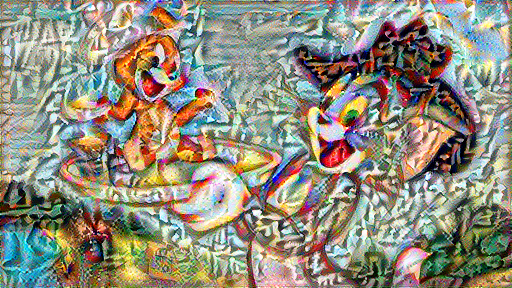

Training Progress: 100%|██████████| 100/100 [26:09<00:00, 15.70s/it]

Train step: 100


In [ ]:
# Define style and content weight
style_weight =  2e-2
content_weight = 1e-2

# Define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=20.0, decay_steps=100, decay_rate=0.50
    )
)

# Start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image,
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    var_weight=0, optimizer=adam, epochs=10, steps_per_epoch=10)

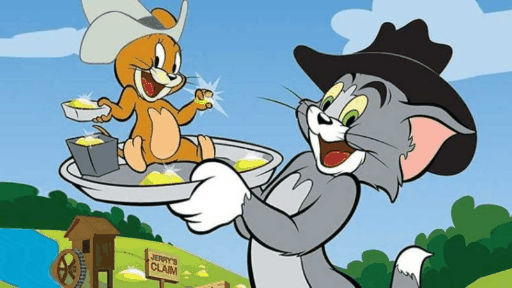

In [ ]:
# Display GIF of Intermedite Outputs
GIF_PATH = 'style_transfer.gif'
gif_images = [np.squeeze(image.numpy().astype(np.uint8), axis=0) for image in display_images]
gif_path = create_gif(GIF_PATH, gif_images)
display_gif(gif_path)

## Total Variation Loss

A common issue with the above implementation is the generation of images with high-frequency artifacts. This can be observed when analyzing the frequency variations in the image. Below, we have defined a few helper functions to help with this analysis.

In [ ]:
# Plot Utilities

def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var


def plot_deltas_for_single_image(x_deltas, y_deltas, name="Original", row=1):
  plt.figure(figsize=(14,10))
  plt.subplot(row,2,1)
  plt.yticks([])
  plt.xticks([])

  clipped_y_deltas = clip_image_values(2*y_deltas+0.5, min_value=0.0, max_value=1.0)
  imshow(clipped_y_deltas, "Horizontal Deltas: {}".format(name))

  plt.subplot(row,2,2)
  plt.yticks([])
  plt.xticks([])

  clipped_x_deltas = clip_image_values(2*x_deltas+0.5, min_value=0.0, max_value=1.0)
  imshow(clipped_x_deltas, "Vertical Deltas: {}".format(name))


def plot_deltas(original_image_deltas, stylized_image_deltas):
  orig_x_deltas, orig_y_deltas = original_image_deltas

  stylized_x_deltas, stylized_y_deltas = stylized_image_deltas

  plot_deltas_for_single_image(orig_x_deltas, orig_y_deltas, name="Original")
  plot_deltas_for_single_image(stylized_x_deltas, stylized_y_deltas, name="Stylized Image", row=2)

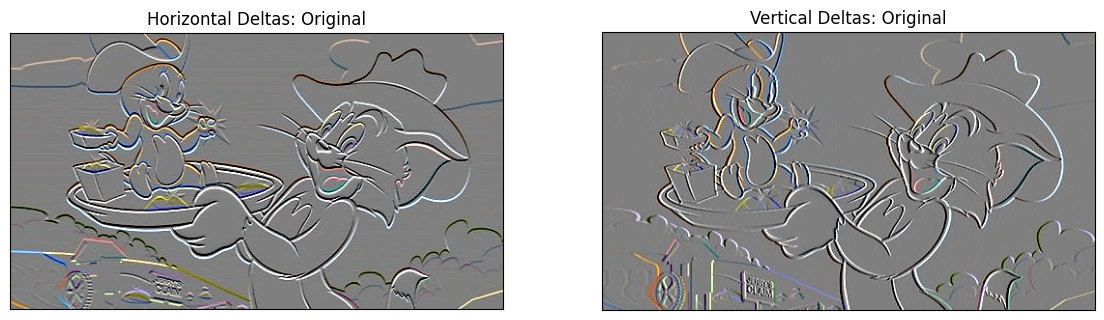

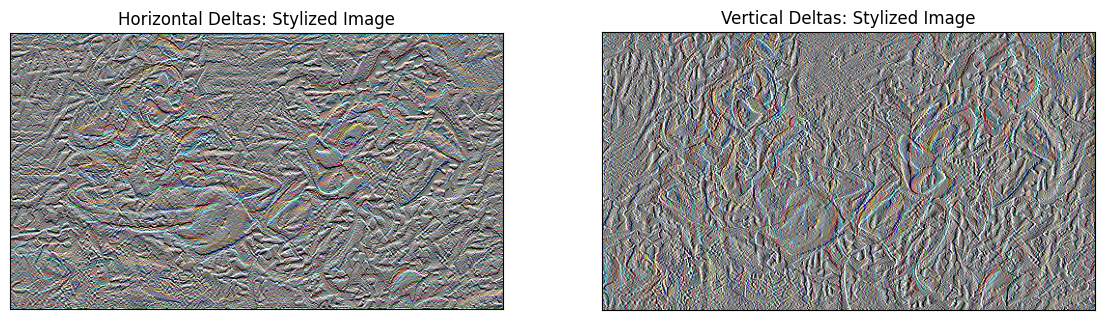

In [ ]:
# Display the frequency variations

original_x_deltas, original_y_deltas = high_pass_x_y(
    tf.image.convert_image_dtype(content_image, dtype=tf.float32))

stylized_image_x_deltas, stylized_image_y_deltas = high_pass_x_y(
    tf.image.convert_image_dtype(stylized_image, dtype=tf.float32))

plot_deltas((original_x_deltas, original_y_deltas), (stylized_image_x_deltas, stylized_image_y_deltas))

To mitigate these artifacts, we can introduce an explicit regularization term on the high-frequency components of the image. In style transfer, this is commonly referred to as the *total variation loss*. Let's redefine the `calculate_gradients()` function, this time incorporating a regularization parameter to compute the total variation loss. We've included the total variation weight as a function parameter (i.e., `var_weight`) for easy adjustment if desired.

In [ ]:
def calculate_gradients(image, style_targets, content_targets,
                        style_weight, content_weight, var_weight):
  """ Calculate the gradients of the loss with respect to the generated image
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss

  Returns:
    gradients: gradients of the loss with respect to the input image
  """
  with tf.GradientTape() as tape:

    # Get the style image features
    style_features = get_style_image_features(image)

    # Get the content image features
    content_features = get_content_image_features(image)

    # Get the style and content loss
    loss = get_style_content_loss(style_targets, style_features, content_targets,
                                  content_features, style_weight, content_weight)

    # Add the total variation loss
    loss += var_weight*tf.image.total_variation(image)

  # Calculate gradients of loss with respect to the image
  gradients = tape.gradient(loss, image)

  return gradients

## Re-running the Optimization

Let's execute the style transfer loop again, this time considering the total variation loss.

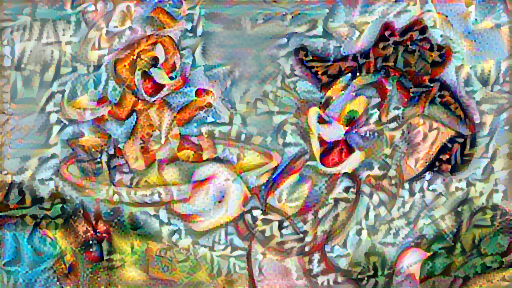

Training Progress: 100%|██████████| 100/100 [26:07<00:00, 15.68s/it]

Train step: 100


In [ ]:
style_weight =  2e-2
content_weight = 1e-2
var_weight = 2

adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=20.0, decay_steps=100, decay_rate=0.50
    )
)

stylized_image_reg, display_images_reg = fit_style_transfer(style_image=style_image, content_image=content_image,
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    var_weight=var_weight, optimizer=adam, epochs=10, steps_per_epoch=10)

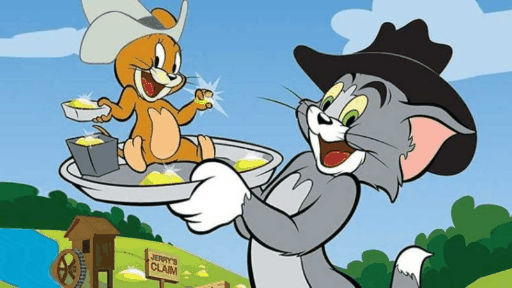

In [ ]:
# Display GIF
GIF_PATH = 'style_transfer_reg.gif'
gif_images_reg = [np.squeeze(image.numpy().astype(np.uint8), axis=0) for image in display_images_reg]
gif_path_reg = create_gif(GIF_PATH, gif_images_reg)
display_gif(gif_path_reg)

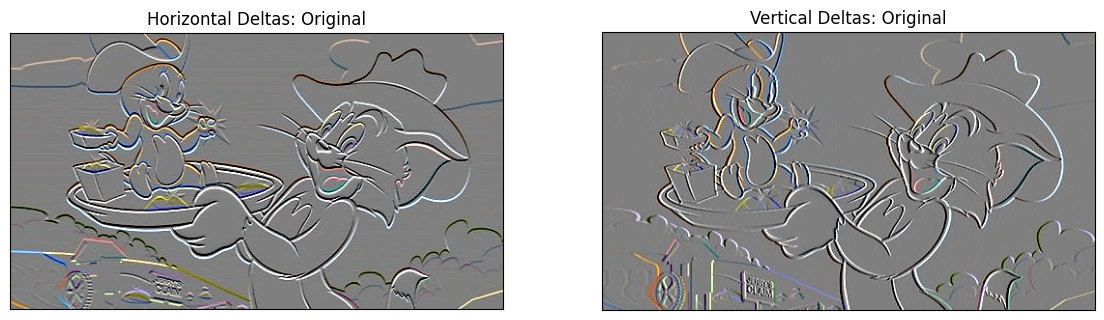

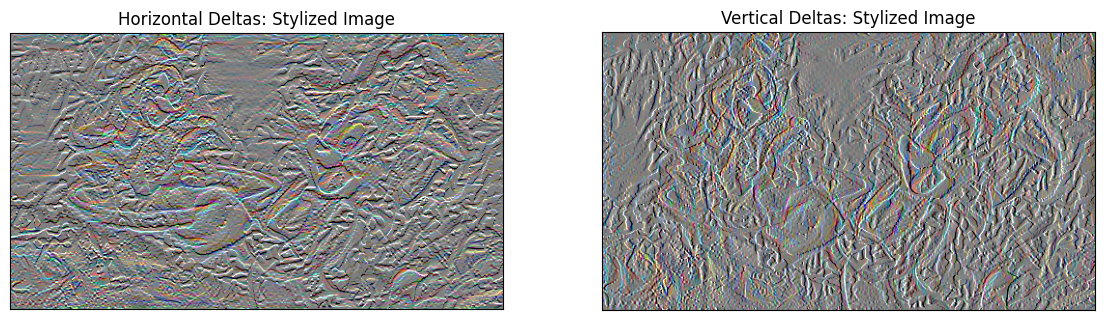

In [ ]:
# Display Frequency Variations

original_x_deltas, original_y_deltas = high_pass_x_y(
    tf.image.convert_image_dtype(content_image, dtype=tf.float32))

stylized_image_reg_x_deltas, stylized_image_reg_y_deltas = high_pass_x_y(
    tf.image.convert_image_dtype(stylized_image_reg, dtype=tf.float32))

plot_deltas((original_x_deltas, original_y_deltas), (stylized_image_reg_x_deltas, stylized_image_reg_y_deltas))

We'll observe that the variations are generally smoother with the additional parameter. Here are the stylized images again, with and without regularization, for comparison.

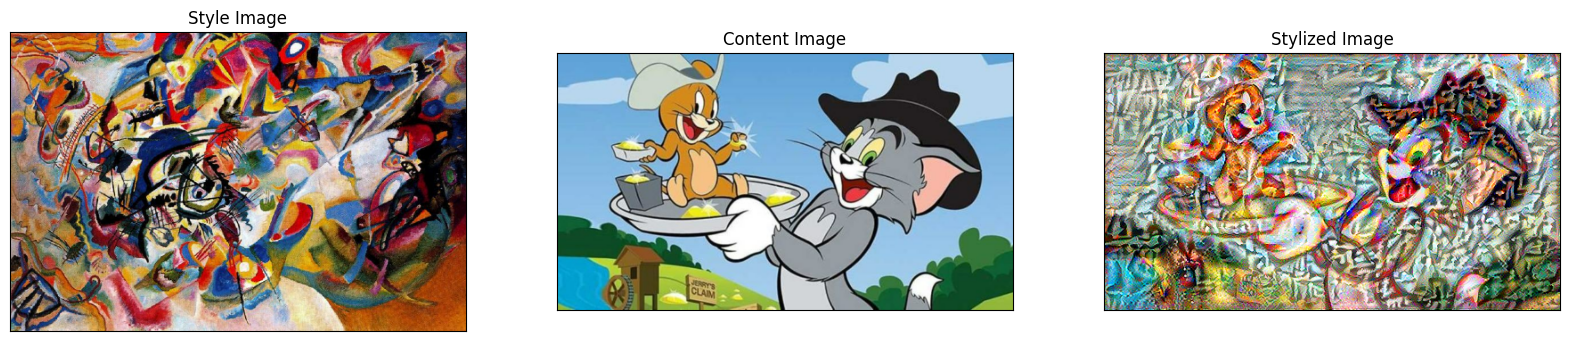

In [ ]:
show_images_with_objects([style_image, content_image, stylized_image], titles=['Style Image', 'Content Image', 'Stylized Image'])

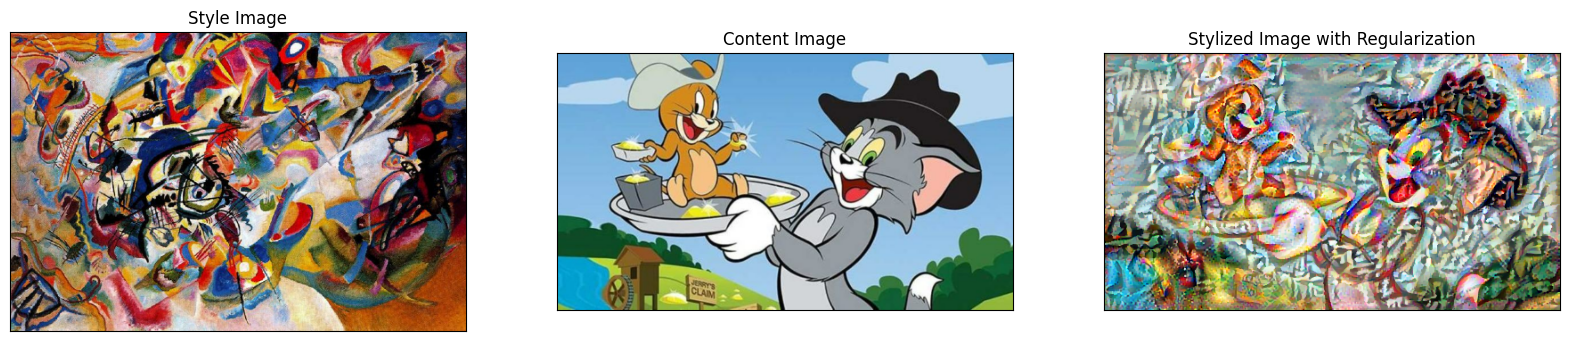

In [ ]:
show_images_with_objects([style_image, content_image, stylized_image_reg], titles=['Style Image', 'Content Image', 'Stylized Image with Regularization'])